<a href="https://colab.research.google.com/github/StephenTGibson/MScDataSci_21-22/blob/main/COMP702-MScProject/Devito_numerical_solver_to_generate_solution_to_1D_Burgers'_equation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.devitoproject.org/devito/index.html

In [1]:
# install devito
!pip install devito &> /dev/null

In [123]:
# import libraries and tools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from devito import Grid, TimeFunction, Operator, Constant, Eq, solve, first_derivative, left

In [109]:
# define viscosity
nu = 0.01/np.pi

In [110]:
# define discretisation

# extent x direction
X = 2.0
# number of x grid points
nx = 1001
# x direction step size
dx = X / (nx - 1)

# time extent (total duration)
T = 1 
# time step
dt = 1e-4
# number of time points
nt = int((T / dt) + 1)

In [111]:
# create 1D grid and assign dimension variable names
grid = Grid(shape=(nx), extent=(X))

x = grid.dimensions
t = grid.stepping_dim

In [112]:
# create time function on grid
# space order of 2 to enable 2nd derivative
u = TimeFunction(name='u', grid=grid, space_order=2)

In [113]:
# create constant (viscosity)
a = Constant(name='a')
# define 1D Burgers' equation
equation_u = Eq(u.dt + u*u.dxl, a*u.dx2)
equation_u

Eq(u(t, x)*Derivative(u(t, x), x) + Derivative(u(t, x), t), a*Derivative(u(t, x), (x, 2)))

In [114]:
# create stencil by solving for next time step
stencil_u = solve(equation_u, u.forward)
stencil_u

dt*(a*Derivative(u(t, x), (x, 2)) - u(t, x)*Derivative(u(t, x), x) + u(t, x)/dt)

In [115]:
# define equation for next time step
update_u = Eq(u.forward, stencil_u)
update_u

Eq(u(t + dt, x), dt*(a*Derivative(u(t, x), (x, 2)) - u(t, x)*Derivative(u(t, x), x) + u(t, x)/dt))

In [116]:
# define boundary conditions
# u = 0 at min and max extent of x
boundaryConditions = [Eq(u[t+1, 0], 0.)]
boundaryConditions += [Eq(u[t+1, nx], 0.)]

In [117]:
# define operator based on equation and boundary conditions
op = Operator([update_u] + boundaryConditions)

In [118]:
# set solution space to 0s
u.data[:] = 0

# create a dummy x array from -1 to +1
dummyX = np.arange(-1, 1+dx, dx)

# set initial conditions using dummy x array
u.data[0] = -1 * np.sin(np.pi * dummyX)

In [119]:
# define number of time steps to compute before storing result for plotting
batchSize = 100

# initialise empty array to store computed solution
results = np.zeros((nx, int(nt / batchSize)))
# store initial conditions in results array
results[:,0] = u.data[0].copy()

# iterate over result steps
# start from 1 not 0 as results at step 0 are the initial conditions
for timeStep in range(1, int(nt / batchSize)):
    # compute solution after batchSize time steps
    summary = op.apply(time=batchSize, dt=dt, a=nu)
    # store computed solution in results array
    results[:,timeStep] = u.data[0].copy()

Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator

In [120]:
# define arrays for creating meshgrid for plotting solution results
xPlot = np.arange(0, T, dt*batchSize)
yPlot = np.arange(-1, 1+dx, dx)
# create meshgrid from arrays
X, Y = np.meshgrid(xPlot, yPlot)

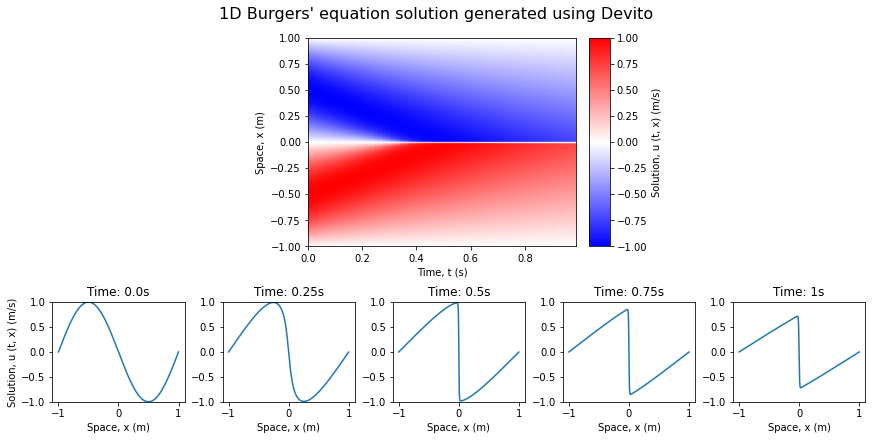

In [178]:
# create figure using gridspec to structure subplots
fig = plt.figure(
    figsize=(12, 6),
    constrained_layout=True
    )
gs = GridSpec(3, 20, figure=fig)

# add main solution plot
solutionAx = fig.add_subplot(gs[:2,5:15])
solutionPlot = solutionAx.pcolormesh(X, Y, results, cmap='bwr')
solutionAx.set_xlabel('Time, t (s)')
solutionAx.set_ylabel('Space, x (m)')
cbar = fig.colorbar(solutionPlot, use_gridspec=True)
cbar.set_label('Solution, u (t, x) (m/s)')

# iteratively create solution snapshot subplots
for i in range(5):
    tPlot = fig.add_subplot(gs[2, i*4:(i+1)*4])    
    if i < 4:
        tPlot.plot(Y[:, i*(Y.shape[1]//4)], results[:, i*(Y.shape[1]//4)])
        tPlot.set_title('Time: ' + str(i*X[0, X[0].shape[0]//4]) + 's')
    else:
        tPlot.plot(Y[:, -1], results[:, -1])
        tPlot.set_title('Time: ' + str(T) + 's')
    
    tPlot.set_ylim([-1, 1])
    tPlot.set_xlabel('Space, x (m)')
    if i == 0:
        tPlot.set_ylabel('Solution, u (t, x) (m/s)')

# figure title
fig.suptitle("1D Burgers' equation solution generated using Devito", fontsize=16)

# fig.savefig("1D Burgers' - devito", bbox_inches='tight')
plt.show()